In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/garbage-classification


In [ ]:
import os

path = "/kaggle/input/garbage-classification"

# List files in the dataset folder
os.listdir(path)

['one-indexed-files-notrash_val.txt',
 'one-indexed-files-notrash_train.txt',
 'Garbage classification',
 'garbage classification',
 'zero-indexed-files.txt',
 'one-indexed-files.txt',
 'one-indexed-files-notrash_test.txt']

In [ ]:
!cp -r /kaggle/input/garbage-classification /content/kaggle_imageclass

In [ ]:
import numpy as np
import pandas as pd
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras as keras
import tensorflow as tf

from PIL import Image
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, GlobalAveragePooling2D
from keras.models import Model, Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [ ]:
dataset_dir = "kaggle_imageclass/Garbage classification/Garbage classification"  # adjust if needed (case-sensitive!)
# Dictionary to save our classes
classes = ["cardboard", "glass", "metal", "paper", "plastic", "trash"]

In [ ]:
# Create folders for train, val, test
for split in ['train', 'val', 'test']:
    for cls in classes:
        os.makedirs(os.path.join(split, cls), exist_ok=True)

In [ ]:
import shutil
# Split each class into train/val/test
for cls in classes:
    cls_path = os.path.join(dataset_dir, cls)
    images = os.listdir(cls_path)

    train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
    val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

# Copy images to respective folders

    for img in train_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join('train', cls, img))
    for img in val_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join('val', cls, img))
    for img in test_imgs:
        shutil.copy(os.path.join(cls_path, img), os.path.join('test', cls, img))

print("Dataset split completed!")

Dataset split completed!


In [ ]:
# Image parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
classes = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

## Data Augmentation

In [ ]:
# Data generators with augmentation for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,          # Normalize pixels
    rotation_range=15,       # Random rotation
    width_shift_range=0.1,   # Horizontal shift
    height_shift_range=0.1,  # Vertical shift
    zoom_range=0.2,          # Zoom
    horizontal_flip=True,    # Horizontal flip
    validation_split=0.15    # Split 15% for validation
)

In [ ]:
# Train generator
train_generator = train_datagen.flow_from_directory(
    'train',                  # Path to training folder
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Validation generator
val_generator = train_datagen.flow_from_directory(
    'val',                    # Path to validation folder
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Test generator (only rescale)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 1766 images belonging to 6 classes.
Found 378 images belonging to 6 classes.
Found 383 images belonging to 6 classes.


## EDA

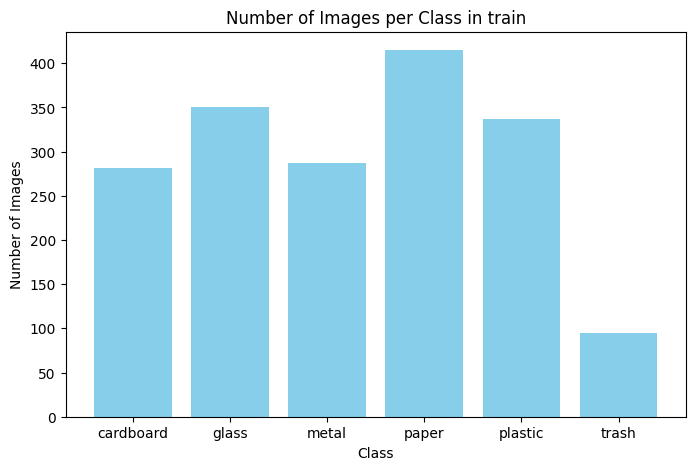

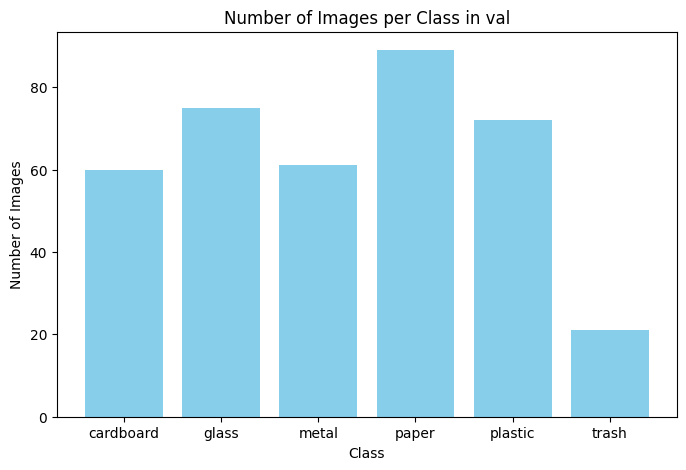

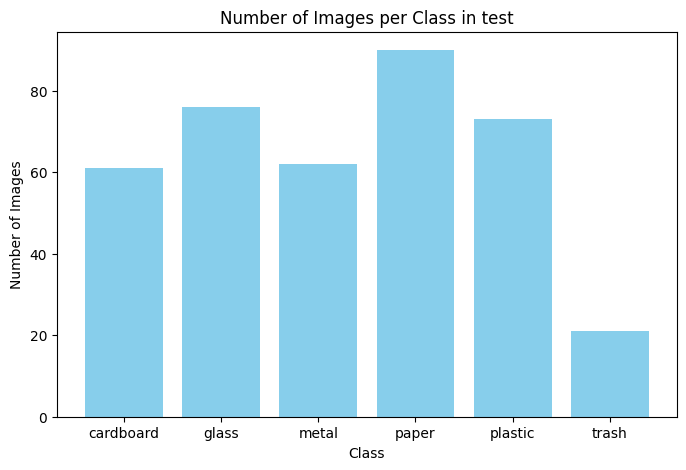

In [ ]:
def plot_class_distribution(folder_path):
    counts = {}
    for cls in classes:
        cls_folder = os.path.join(folder_path, cls)
        counts[cls] = len(os.listdir(cls_folder))
    plt.figure(figsize=(8,5))
    plt.bar(counts.keys(), counts.values(), color='skyblue')
    plt.title(f"Number of Images per Class in {folder_path}")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.show()

plot_class_distribution('train')
plot_class_distribution('val')
plot_class_distribution('test')

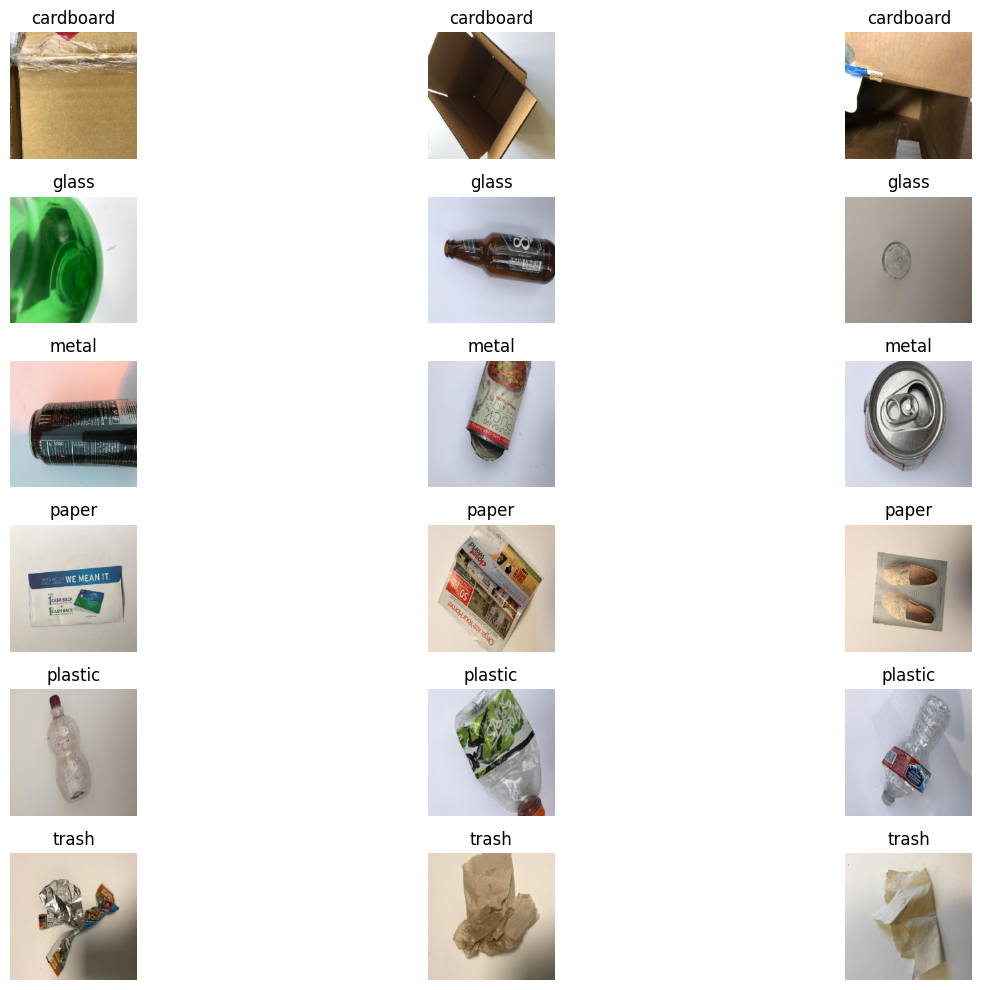

In [ ]:
def show_sample_images(folder_path, num_images=3):
    plt.figure(figsize=(15,10))
    for idx, cls in enumerate(classes):
        cls_folder = os.path.join(folder_path, cls)
        images = os.listdir(cls_folder)[:num_images]
        for i, img_name in enumerate(images):
            img_path = os.path.join(cls_folder, img_name)
            img = tf.keras.preprocessing.image.load_img(img_path, target_size=IMG_SIZE)
            img = tf.keras.preprocessing.image.img_to_array(img)/255.0
            plt.subplot(len(classes), num_images, idx*num_images + i + 1)
            plt.imshow(img)
            plt.title(cls)
            plt.axis('off')
    plt.tight_layout()
    plt.show()

show_sample_images('train')

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 6

## Spliting Data

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Data generators
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15
)

train_generator = train_datagen.flow_from_directory(
    'train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 1503 images belonging to 6 classes.
Found 263 images belonging to 6 classes.


## Building and Training Model

In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
# Load MobileNetV2 base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # Freeze base layers

# Add custom classifier layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.5102 - loss: 1.2621 - val_accuracy: 0.6958 - val_loss: 0.8314
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 467ms/step - accuracy: 0.7699 - loss: 0.6126 - val_accuracy: 0.7529 - val_loss: 0.6445
Epoch 3/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 447ms/step - accuracy: 0.8364 - loss: 0.4473 - val_accuracy: 0.7452 - val_loss: 0.6220
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 467ms/step - accuracy: 0.8808 - loss: 0.3334 - val_accuracy: 0.7490 - val_loss: 0.6984
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 475ms/step - accuracy: 0.8649 - loss: 0.3419 - val_accuracy: 0.7795 - val_loss: 0.6185
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 479ms/step - accuracy: 0.9245 - loss: 0.2427 - val_accuracy: 0.7490 - val_loss: 0.6327
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 21s 457ms/step - accuracy: 0.9325 - loss: 0.2183 - val_accuracy: 0.7719 - val_loss: 0.7177
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 24s 506ms/step - accuracy: 0.9356 - loss: 0.1990 - val_accurac

## Testing the Model on test data

In [ ]:
# Assuming test images are in 'test' folder
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'test',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Evaluate model
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Found 383 images belonging to 6 classes.
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 376ms/step - accuracy: 0.8009 - loss: 0.8210
Test Accuracy: 81.98%


In [ ]:
# Save trained model
model.save("GARBAGE_classifier.h5")

## Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict labels for test set
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Classification report
target_names = list(test_generator.class_indices.keys())
report = classification_report(y_true, y_pred_classes, target_names=target_names)
print("Classification Report:\n", report)

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 482ms/step
Confusion Matrix:
 [[49  0  2  8  1  1]
 [ 0 58  9  1  8  0]
 [ 0  3 51  1  6  1]
 [ 3  1  0 83  2  1]
 [ 0  5  2  3 61  2]
 [ 0  0  2  3  4 12]]
Classification Report:
               precision    recall  f1-score   support

   cardboard       0.94      0.80      0.87        61
       glass       0.87      0.76      0.81        76
       metal       0.77      0.82      0.80        62
       paper       0.84      0.92      0.88        90
     plastic       0.74      0.84      0.79        73
       trash       0.71      0.57      0.63        21

    accuracy                           0.82       383
   macro avg       0.81      0.79      0.80       383
weighted avg       0.82      0.82      0.82       383



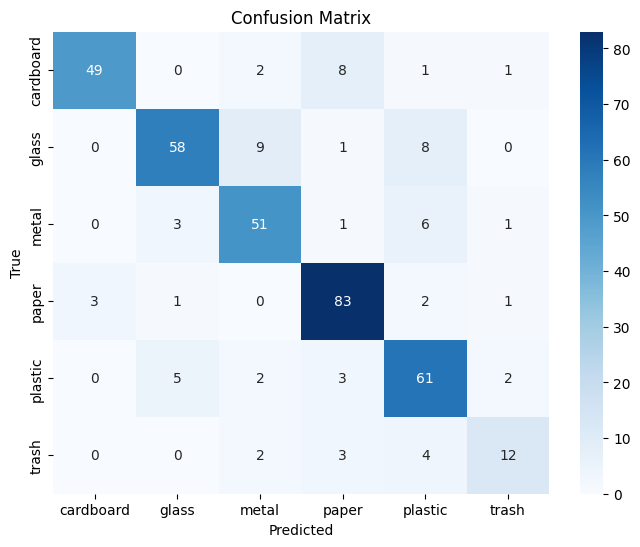

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=target_names, yticklabels=target_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()